In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
np.random.seed(42)
tf.random.set_seed(42)
input_steps = 6   
output_steps = 6  


In [9]:
import pandas as pd
data_file = "data_readed.xlsx"
df = pd.read_excel(data_file)
df.head()


,row,col,datetime,AWS,CAPE,CIN,EWSS,IE,ISOR,KX,...,SLHF,SLOR,SSHF,TCLW,TCW,TCWV,U250,U850,V250,V850
0,0,104,2020-10-01 00:00:00,0.0,197.25,61.953484,-113.054688,-0.000017,0.676296,36.621414,...,-59037,0.023543,-27549,0.373413,59.393524,59.004852,-5.800369,-0.907883,-0.157303,3.689789
1,0,104,2020-10-01 01:00:00,0.0,138.50,9999.000000,-128.285156,-0.000038,0.676296,36.078514,...,-203202,0.023543,-64968,0.274780,59.516571,59.215790,-5.511688,-0.485977,-0.572311,3.517319
2,0,104,2020-10-01 02:00:00,0.0,102.00,9999.000000,-120.671875,-0.000055,0.676296,35.410492,...,-376145,0.023543,-81566,0.194763,59.715759,59.483337,-4.963364,-0.448380,-1.284912,3.182495
3,0,104,2020-10-01 03:00:00,0.0,160.75,9999.000000,-169.191406,-0.000064,0.676296,34.843140,...,-609080,0.023543,-101141,0.187439,60.249374,60.005234,-4.379272,-0.892761,-2.056778,2.465332
4,0,104,2020-10-01 04:00:00,0.0,204.50,213.468903,-304.347656,-0.000112,0.676296,34.893394,...,-654851,0.023543,-97831,0.104156,60.974991,60.775604,-3.959961,-1.550842,-2.280151,1.559830


In [10]:
features = ['AWS', 'CAPE', 'CIN', 'V850', 'KX', 'R250', 'R500', 'U250', 'U850', 'EWSS']

df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values(by='datetime').reset_index(drop=True)
df[features] = df[features].fillna(method='ffill')

# Thực hiện chuẩn hóa z-score cho từng feature
for col in features:
    mean_val = df[col].mean()
    std_val = df[col].std()
    df[col] = (df[col] - mean_val) / std_val

print(df[features].describe())


C:\Users\giakh\AppData\Local\Temp\ipykernel_5400\862231718.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[features] = df[features].fillna(method='ffill')


                AWS          CAPE           CIN          V850            KX  \
count  6.576810e+05  6.576810e+05  6.576810e+05  6.576810e+05  6.576810e+05   
mean   3.634385e-17 -1.064819e-16  5.600669e-17  2.854785e-16  1.369917e-16   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -1.611197e-01 -6.550794e-01 -1.090687e+00 -4.789703e+00 -7.231441e+00   
25%   -1.611197e-01 -6.526251e-01 -1.052129e+00 -5.261229e-01 -2.727899e-01   
50%   -1.611197e-01 -5.386114e-01  9.614154e-01  2.378488e-01  2.444112e-01   
75%   -1.611197e-01  3.018772e-01  9.614154e-01  6.696491e-01  6.307266e-01   
max    5.367483e+01  7.129759e+00  9.614154e-01  2.504911e+00  1.949195e+00   

               R250          R500          U250          U850          EWSS  
count  6.576810e+05  6.576810e+05  6.576810e+05  6.576810e+05  6.576810e+05  
mean  -8.885012e-17  4.442506e-17 -4.840084e-18  9.334448e-18  1.486597e-17  
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000

In [ ]:
def create_sequences(data, input_steps, output_steps):
    """
    data: mảng 2D có shape (T, num_features) từ file Excel (đã được sắp xếp theo thời gian)
    Trả về X với shape (samples, input_steps, num_features) và y với shape (samples, output_steps, num_features)
    """
    X, y = [], []
    total_steps = input_steps + output_steps
    for i in range(len(data) - total_steps + 1):
        X.append(data[i:i+input_steps, :])
        y.append(data[i+input_steps:i+total_steps, :])
    return np.array(X), np.array(y)
data_array = df[features].values
input_steps = 6
output_steps = 6
X_seq, y_seq = create_sequences(data_array, input_steps, output_steps)
print("Shape của X_seq:", X_seq.shape)  
print("Shape của y_seq:", y_seq.shape)  


Shape của X_seq: (657670, 6, 10)
Shape của y_seq: (657670, 6, 10)


In [12]:
num_samples = X_seq.shape[0]
train_size = int(num_samples * 0.8)

X_train = X_seq[:train_size]
y_train = y_seq[:train_size]
X_test = X_seq[train_size:]
y_test = y_seq[train_size:]

print("Số mẫu Train:", X_train.shape[0])
print("Số mẫu Test:", X_test.shape[0])


Số mẫu Train: 526136
Số mẫu Test: 131534


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed

model = Sequential()
model.add(LSTM(50, activation='tanh', return_sequences=True, input_shape=(input_steps, len(features))))
model.add(LSTM(50, activation='tanh', return_sequences=True))
model.add(TimeDistributed(Dense(len(features))))
model.compile(optimizer='adam', loss='mse')
model.summary()


c:\Users\giakh\miniconda3\envs\ai_train\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 6, 50)          │        12,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 6, 50)          │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 6, 10)          │           510 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,910 (128.55 KB)

 Trainable params: 32,910 (128.55 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_rain_prediction_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

history = model.fit(X_train, y_train, 
                    epochs=100, 
                    batch_size=64, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stop, checkpoint])


model.save('rain_prediction_model_final.h5')


Epoch 1/100
8216/8221 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3230
Epoch 1: val_loss improved from inf to 0.78966, saving model to best_rain_prediction_model.h5


8221/8221 ━━━━━━━━━━━━━━━━━━━━ 68s 8ms/step - loss: 0.3230 - val_loss: 0.7897
Epoch 2/100
8217/8221 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2836
Epoch 2: val_loss did not improve from 0.78966
8221/8221 ━━━━━━━━━━━━━━━━━━━━ 65s 8ms/step - loss: 0.2836 - val_loss: 0.8072
Epoch 3/100
8221/8221 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2794
Epoch 3: val_loss did not improve from 0.78966
8221/8221 ━━━━━━━━━━━━━━━━━━━━ 65s 8ms/step - loss: 0.2794 - val_loss: 0.8155
Epoch 4/100
8216/8221 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2770
Epoch 4: val_loss did not improve from 0.78966
8221/8221 ━━━━━━━━━━━━━━━━━━━━ 65s 8ms/step - loss: 0.2770 - val_loss: 0.8174
Epoch 5/100
8216/8221 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2755
Epoch 5: val_loss did not improve from 0.78966
8221/8221 ━━━━━━━━━━━━━━━━━━━━ 66s 8ms/step - loss: 0.2755 - val_loss: 0.8168
Epoch 6/100
8217/8221 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2744
Epoch 6: val_loss did not improve from 0.78966
8221/8221 ━━━━━━━━━━━━━━━

In [ ]:
test_loss = model.evaluate(X_test, y_test)
print("Test Loss (MSE):", test_loss)
y_pred = model.predict(X_test)
y_test_flat = y_test.reshape(-1)
y_pred_flat = y_pred.reshape(-1)

mse = np.mean((y_test_flat - y_pred_flat)**2)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_flat, y_pred_flat)

print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r2)

for i in range(output_steps):
    mse_i = mean_squared_error(y_test[:, i, :], y_pred[:, i, :])
    print(f"MSE cho bước dự báo thứ {i+1}: {mse_i}")


4111/4111 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.8622
Test Loss (MSE): 0.7896629571914673
4111/4111 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
MSE: 0.7896626762297454
RMSE: 0.8886296620244821
R2 Score: 0.4638090824535678
MSE cho bước dự báo thứ 1: 0.8769852125090439
MSE cho bước dự báo thứ 2: 0.8086632684294862
MSE cho bước dự báo thứ 3: 0.7811144537769747
MSE cho bước dự báo thứ 4: 0.7655916141813318
MSE cho bước dự báo thứ 5: 0.7559339615882188
MSE cho bước dự báo thứ 6: 0.7496875468934253


4111/4111 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


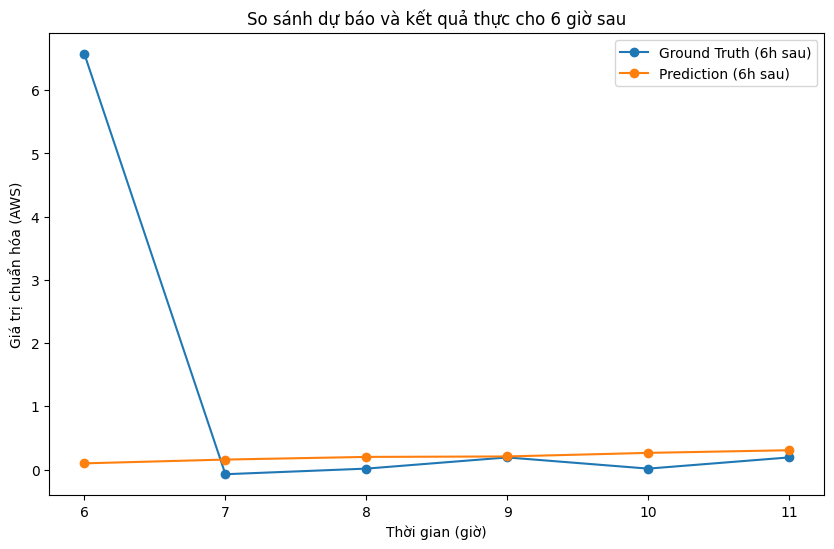

In [ ]:
import matplotlib.pyplot as plt

sample_index = np.random.randint(0, X_test.shape[0])
y_pred = model.predict(X_test)
input_sequence = X_test[sample_index].flatten()  
ground_truth = y_test[sample_index].flatten()      
prediction = y_pred[sample_index].flatten()          

def extract_feature(series, feature_idx=0, steps=6):
    return series.reshape(6, len(features))[:, feature_idx]

input_aws = extract_feature(input_sequence, feature_idx=0)
ground_truth_aws = extract_feature(ground_truth, feature_idx=0)
prediction_aws = extract_feature(prediction, feature_idx=0)

plt.figure(figsize=(10, 6))
plt.plot(range(input_steps, input_steps+output_steps), ground_truth_aws, marker='o', label='Ground Truth (6h sau)')
plt.plot(range(input_steps, input_steps+output_steps), prediction_aws, marker='o', label='Prediction (6h sau)')
plt.xlabel("Thời gian (giờ)")
plt.ylabel("Giá trị chuẩn hóa (AWS)")
plt.title("So sánh dự báo và kết quả thực cho 6 giờ sau")
plt.legend()
plt.show()


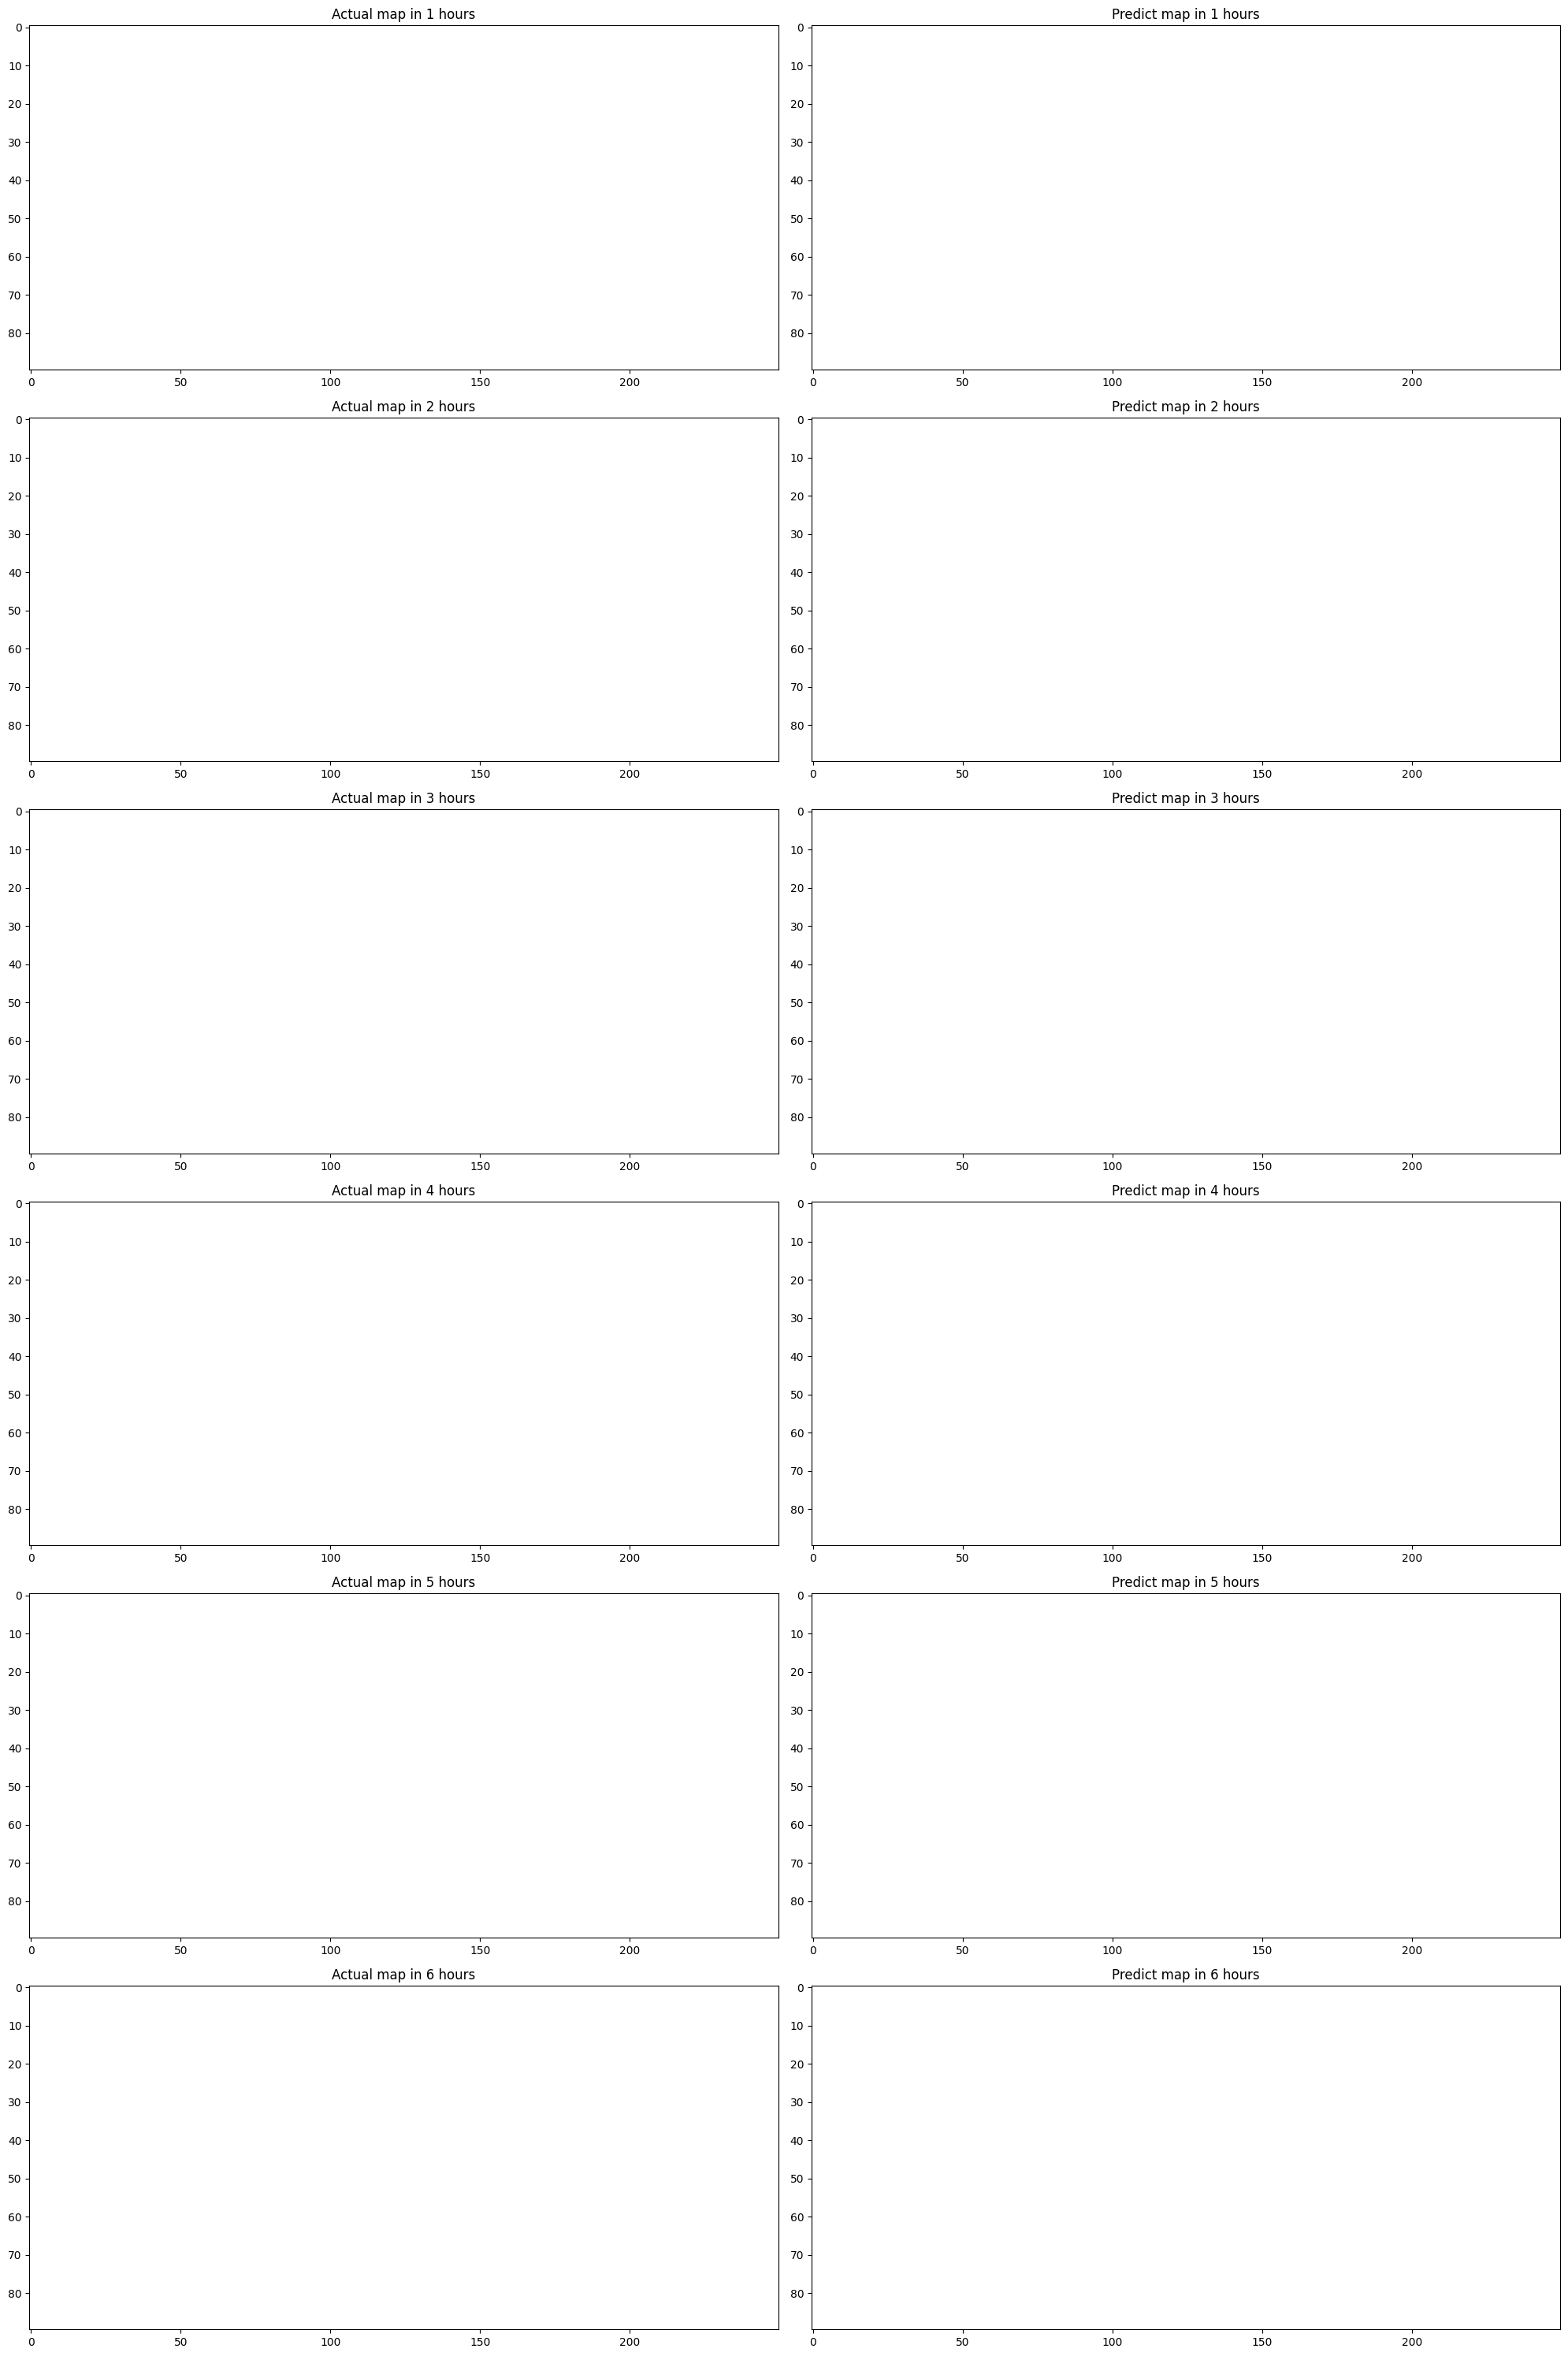

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

HEIGHT = 90
WIDTH = 250
pre_time_step = input_steps   
aft_time_step = output_steps  

tmp_data = [[[] for _ in range(WIDTH)] for _ in range(HEIGHT)]
for idx, row in df.iterrows():
    r = int(row['row'])
    c = int(row['col'])
    features_list = [row[feat] for feat in features]
    tmp_data[r][c].append(features_list)
predict_map = np.zeros((aft_time_step, HEIGHT, WIDTH))
actual_map = np.zeros((aft_time_step, HEIGHT, WIDTH))
for i in range(HEIGHT):
    for j in range(WIDTH):
        if len(tmp_data[i][j]) == pre_time_step + aft_time_step:
            X_ex = np.array(tmp_data[i][j][:pre_time_step]).reshape(1, pre_time_step, len(features))
            y_ex = np.array(tmp_data[i][j][pre_time_step:]).reshape(1, aft_time_step, len(features))
            y_predex = model.predict(X_ex)
            for z in range(aft_time_step):
                predict_map[z, i, j] = y_predex[0][z, 0]
                actual_map[z, i, j] = y_ex[0][z, 0]
predict_map[predict_map == 0] = np.nan
actual_map[actual_map == 0] = np.nan
cmap = plt.cm.viridis(np.arange(plt.cm.viridis.N))
cmap[0] = np.array([1, 1, 1, 1])
cmap = mcolors.ListedColormap(cmap)
fig, axes = plt.subplots(aft_time_step, 2, figsize=(20, 5 * aft_time_step))
for z in range(aft_time_step):
    axes[z, 0].imshow(actual_map[z], cmap=cmap, aspect='auto')
    axes[z, 0].set_title(f'Actual map in {z+1} hours')
    axes[z, 1].imshow(predict_map[z], cmap=cmap, aspect='auto')
    axes[z, 1].set_title(f'Predict map in {z+1} hours')
plt.tight_layout()
plt.show()
